## Total Investigation Time & Average Bout Duration

In [52]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

from hc_extension import *
from Hab_Dishab.hd_extension import get_trial_dataframes, create_metadata_dataframe

In [53]:
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all_csvs/mpfc_csvs"
brain_region = '#FFAF00'

In [54]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p6-240823-105552/Notes.txt
read from t=0s to t=1807.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p2-240508-101128/Notes.txt
read from t=0s to t=1820.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp4-250121-065035/Notes.txt
read from t=0s to t=1876.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p7-240824-053845/Notes.txt
read from t=0s to t=1790.87s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp5-250121-110144/Notes.txt
read from t=0s to t=1895.67s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp3-

In [55]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions, first_only=False)

Processing behaviors for p6-240823-105552...
Processing behaviors for p2-240508-101128...
Processing behaviors for pp4-250121-065035...
Processing behaviors for p7-240824-053845...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp6-250121-114116...
Processing behaviors for p1-240508-084607...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Processing behaviors for p5-240823-093250...
Processing behaviors for p3-240509-070801...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp2-250121-123301...
Processing behaviors for p4-240509-083601...


In [56]:
# Step 1: Get trial data
trial_data = get_trial_dataframes(experiment)

# Step 2: Trim Short_Term-1 to first 5 minutes
trimmed_data = trim_short_term_to_5min(trial_data)

# Step 3: Create metadata dataframe with trimmed data
metadata_df = create_metadata_dataframe(trimmed_data, behavior="Investigation")
metadata_df.head()


,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration
0,p6,Long_Term-1,Investigation,15.500,1.291667
1,p6,Novel-1,Investigation,60.700,6.744444
2,p6,Short_Term-2,Investigation,9.800,1.633333
3,p6,Short_Term-1,Investigation,22.700,2.522222
4,p2,Long_Term-1,Investigation,60.931,3.046550


In [57]:
new_da_df = metadata_df.copy() 

# Desired bout order
desired_bout_order = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]
clean_labels = ["Acq-ST", "Short Term", "Long Term", "Novel"]
xtick_colors = ["teal", "blue", "purple", "orange"]

# Map the bout column to a categorical with desired order
df = new_da_df[new_da_df["Bout"].isin(desired_bout_order)].copy()
df["Bout"] = pd.Categorical(df["Bout"], categories=desired_bout_order, ordered=True)

In [58]:
from scipy.stats import ttest_rel
import numpy as np
import matplotlib.pyplot as plt

def hc_plot_behavior_times_across_bouts_gray(metadata_df,
                                             y_col="Total Investigation Time",
                                             behavior=None,
                                             title='Mean Across Bouts',
                                             ylabel=None,
                                             custom_xtick_labels=None,
                                             custom_xtick_colors=None,
                                             ylim=None,
                                             bar_color='#00B7D7',
                                             yticks_increment=None,
                                             xlabel='Agent',
                                             figsize=(12, 7),
                                             pad_inches=0.1,
                                             save=False,
                                             save_name=None):
    """
    Plots behavior times across bouts with individual lines and prints t-test results.
    """
    # 1) Filter by behavior if specified
    if behavior is not None:
        metadata_df = metadata_df[metadata_df["Behavior"] == behavior].copy()
        if metadata_df.empty:
            raise ValueError(f"No data found for behavior='{behavior}'.")

    if y_col not in metadata_df.columns:
        raise ValueError(f"'{y_col}' not found in metadata_df columns.")

    # 2) Pivot the DataFrame
    pivot_df = metadata_df.pivot(index="Subject", columns="Bout", values=y_col)

    # 3) Compute mean and SEM
    mean_values = pivot_df.mean()
    sem_values = pivot_df.sem()

    # 4) Plotting
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(
        pivot_df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    for subject in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[subject],
                linestyle='-', color='gray', alpha=0.5,
                linewidth=2.5, zorder=1)
        ax.scatter(pivot_df.columns, pivot_df.loc[subject],
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Axis labels
    if ylabel is None:
        ylabel = y_col
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=30)

    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=30)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=30)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    plt.tight_layout()
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()

    # --- Paired T-Test Results ---
    bouts = pivot_df.columns.tolist()
    print("\nPaired t-test results (all combinations):")
    for i in range(len(bouts)):
        for j in range(i + 1, len(bouts)):
            b1, b2 = bouts[i], bouts[j]
            df_pair = pivot_df[[b1, b2]].dropna()
            if len(df_pair) > 1:
                t_stat, p_val = ttest_rel(df_pair[b1], df_pair[b2])
                sig = "ns"
                if p_val < 0.001:
                    sig = "***"
                elif p_val < 0.01:
                    sig = "**"
                elif p_val < 0.05:
                    sig = "*"
                print(f"{b1} vs {b2}: p = {p_val:.4f} ({sig})")


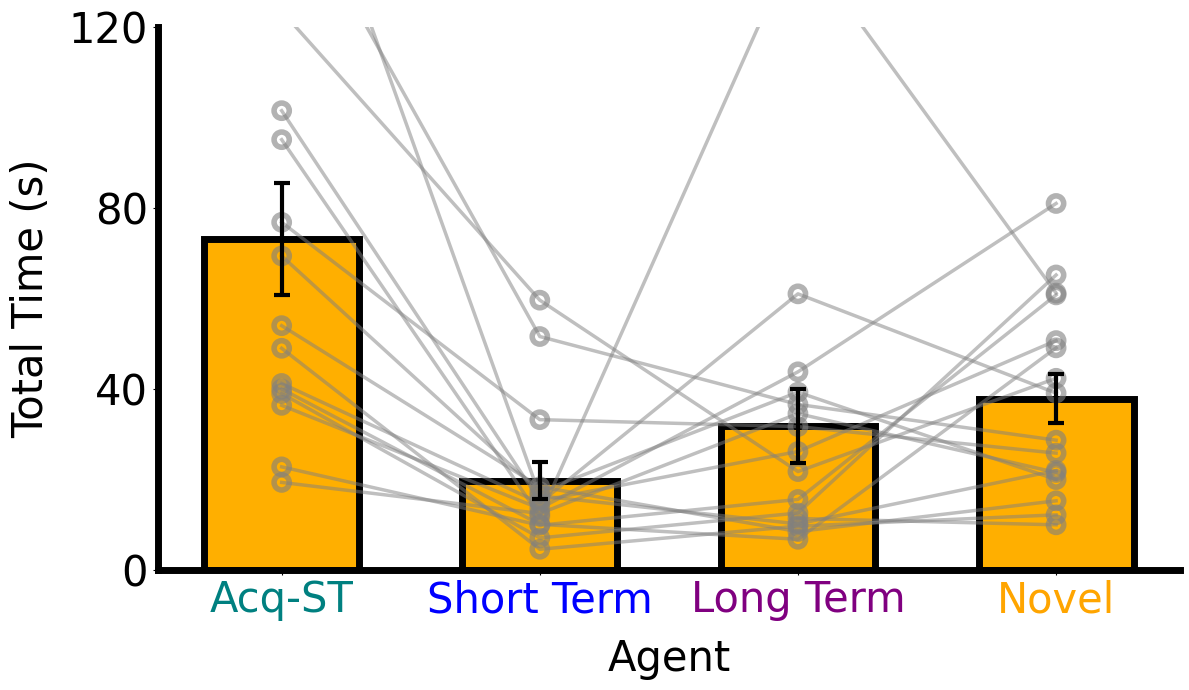


Paired t-test results (all combinations):
Short_Term-1 vs Short_Term-2: p = 0.0001 (***)
Short_Term-1 vs Long_Term-1: p = 0.0155 (*)
Short_Term-1 vs Novel-1: p = 0.0378 (*)
Short_Term-2 vs Long_Term-1: p = 0.1863 (ns)
Short_Term-2 vs Novel-1: p = 0.0173 (*)
Long_Term-1 vs Novel-1: p = 0.4744 (ns)


In [59]:
hc_plot_behavior_times_across_bouts_gray(
    df,
    y_col="Total Investigation Time",
    title=None,
    ylabel="Total Time (s)",
    custom_xtick_labels=clean_labels,
    custom_xtick_colors=xtick_colors,
    ylim=(0,120),
    yticks_increment=40,
    bar_color=brain_region,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1,
    save=True,
    save_name="mPFC_C1-3_TIT"
)

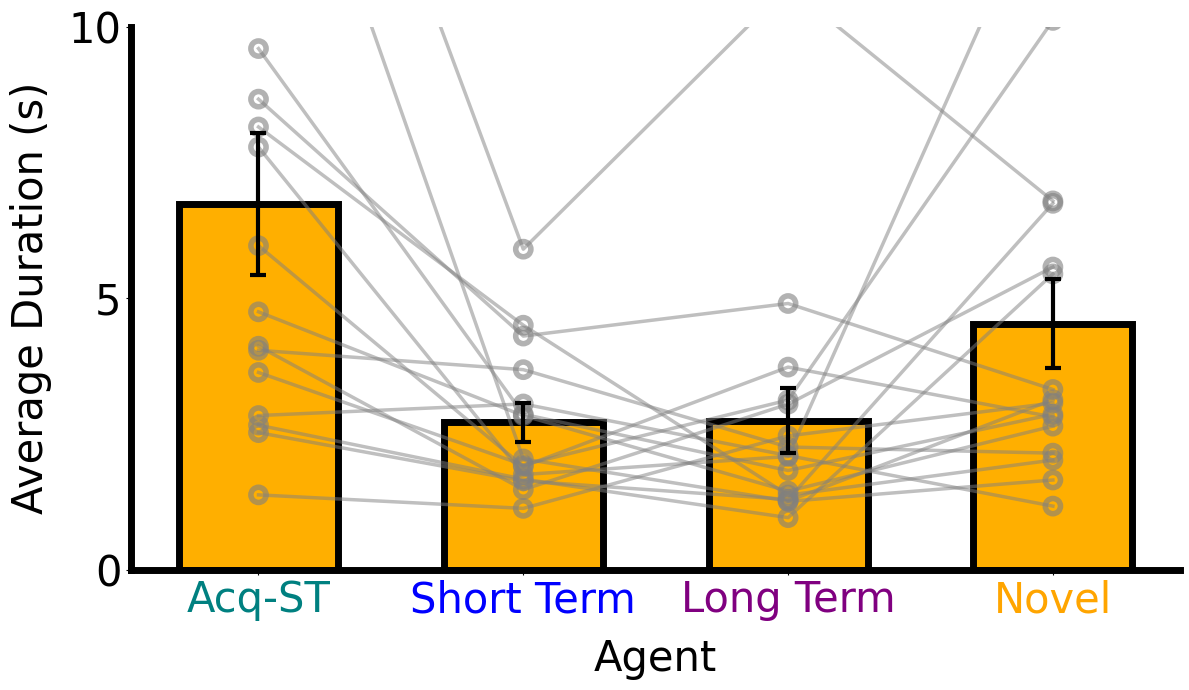


Paired t-test results (all combinations):
Short_Term-1 vs Short_Term-2: p = 0.0031 (**)
Short_Term-1 vs Long_Term-1: p = 0.0025 (**)
Short_Term-1 vs Novel-1: p = 0.2068 (ns)
Short_Term-2 vs Long_Term-1: p = 0.7934 (ns)
Short_Term-2 vs Novel-1: p = 0.0638 (ns)
Long_Term-1 vs Novel-1: p = 0.0689 (ns)


In [60]:
hc_plot_behavior_times_across_bouts_gray(
    df,
    y_col='Average Bout Duration',
    title=None,
    ylabel="Average Duration (s)",
    custom_xtick_labels=clean_labels,
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0,10),
    yticks_increment=5,
    bar_color=brain_region,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1,
    save=True,
    save_name="mPFC_C1-3_ABD"
)

## Standard DA

In [ ]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='standard'                 # Consider only the first investigation event per bout
)

In [ ]:
# Mapping: Real Bout Labels -> Legend Labels
label_mapping = {
    'Short_Term-1': 'Acq-ST',
    'Short_Term-2': 'Short Term',
    'Long_Term-1': 'Long Term',
    'Novel-1': 'Novel'
}

# Define plotting order of real bout labels
line_order = ['Short_Term-1', 'Short_Term-2', 'Long_Term-1', 'Novel-1']

# Matching colors for legend labels (poster order)
custom_colors = ['#00B7D7','#0045A6','#A839A4','#E06928']  # Teal, Dark Blue, Purple, Orange

# Matching legend labels (poster)
custom_legend_labels = ['Acq - ST', 'Short Term', 'Long Term', 'Novel']

plot_da_metrics_combined_oneplot_integrated(experiment,
                                                metric_name="Max Peak", 
                                                title="NAc C1+2: Standard DA (Peak), 1st Investigation", 
                                                ylabel="Peak standard Z-score ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=custom_colors, 
                                                ylim=(-1, 11), 
                                                bar_color=brain_region, 
                                                yticks_increment=2, 
                                                figsize=(14,8), 
                                                pad_inches=0.1,
                                                save=None,
                                                save_name = "NAc_C12_Standard_Peak"
                                                )

# Mean Z-scored ∆F/F

### With Colored Identities

In [ ]:
plot_da_metrics_colored_combined_oneplot_integrated(experiment,
                                                metric_name="Max Peak", 
                                                title="Standard DA (Peak), 1st Investigation", 
                                                ylabel="Peak standard Z-score ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(-1, 11), 
                                                bar_color=brain_region, 
                                                yticks_increment=2, 
                                                figsize=(14,8), 
                                                pad_inches=0.1,
                                                save=None,
                                                save_name = "NAc_C3_Standard_Peak"
                                                )

## Bout Duration vs. Standard Peak DA

In [ ]:
#agent_colors = {'Acq-ST': '#00B7D7', 'Novel': '#E06928'}
#agent_labels = {'Short_Term': 'Acq-ST','Novel': 'Novel'}

agents_of_interest = ['Short_Term-1','Novel-1']
agent_colors = {'Acq-ST': '#00B7D7', 'Novel': '#E06928'}
agent_labels = {'Short_Term': 'Acq-ST','Novel': 'Novel'}

points_df = plot_da_vs_duration_by_agent(
    experiment=experiment,
    agents_of_interest=agents_of_interest,
    agent_colors=agent_colors,
    agent_labels=agent_labels,
    title="Novel (mPFC C1-3): Bout Duration vs. Standard Peak DA",
    da_metric='Max Peak',  # or 'Max Peak', or 'Mean Z-score'
    figsize=(14, 8),
    ylim=(0, 80),
    yticks_increment=10,
    xlabel = "Standard Peak ∆F/F",
    legend_loc='upper left',
    save=None,
    save_name="mPFC_Novel"
)
# Baseline Z-scored ∆F/F
# ['#00B7D7','#0045A6','#A839A4','#E06928'], light blue, dark blue, purple, orange

# 00B7D7 (light blue) --> acq-st
# E06928 (orange) --> novel
# A839A4 (purple) --> long term
# 0045A6 (dark blue) --> short term

### Colored

In [ ]:
points_df = plot_da_vs_duration_by_agent_colored(
    experiment=experiment,
    agents_of_interest=agents_of_interest,
    agent_labels=agent_labels,
    title="Novel (mPFC C1-3): Bout Duration vs. Standard Peak DA",
    da_metric='Max Peak',  # or 'Max Peak', or 'Mean Z-score'
    figsize=(14, 8),
    ylim=(0, 80),
    yticks_increment=10,
    xlabel = "Standard Peak ∆F/F",
    legend_loc='upper left'
)

### Flipped Axes

In [ ]:
agents_of_interest = ['Short_Term-1','Novel-1']
agent_colors = {'Acq-ST': '#00B7D7', 'Novel': '#E06928'}
agent_labels = {'Short_Term': 'Acq-ST','Novel': 'Novel'}

'''
agents_of_interest = ['Short_Term-2']
agent_colors = {'Short Term': '#0045A6'}
agent_labels = {'Short_Term': 'Short Term'}
'''
'''
agents_of_interest = ['Long_Term-1']
agent_colors = {'Long Term': '#A839A4'}
agent_labels = {'Long_Term': 'Long Term'}
'''
points_df = plot_da_vs_duration_by_agent_flipped(
    experiment=experiment,
    agents_of_interest=agents_of_interest,
    agent_colors=agent_colors,
    agent_labels=agent_labels,
    title="Novel (mPFC C1-3): Bout Duration vs. Standard Peak DA",
    da_metric='Max Peak',  # or 'Max Peak', or 'Mean Z-score'
    figsize=(14, 8),
    ylim=(0, 10),
    yticks_increment=5,
    ylabel = "Standard Peak ∆F/F",
    legend_loc='upper right',
    save=True,
    save_name="mPFC_Novel"
)

# 00B7D7 (light blue) --> acq-st
# E06928 (orange) --> novel
# A839A4 (purple) --> long term
# 0045A6 (dark blue) --> short term

## DA Decay w/ 1st Investigation

In [ ]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

experiment.compute_all_da_metrics(
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='standard'                 # Consider only the first investigation event per bout
)

df_labeled = create_behavior_labeled_dataframe(
    experiment=experiment,
    behavior="Investigation",
    n_start=1,  # Currently unused in this version, but you can incorporate it if needed
    n_end=5
)

In [ ]:
df_mean = compute_mean_by_bout_label(df_labeled, value_column="Max Peak")

In [ ]:
# Mapping: Real Bout Labels -> Legend Labels
label_mapping = {
    'Short_Term-1': 'Acq-ST',
    'Short_Term-2': 'Short Term',
    'Long_Term-1': 'Long Term',
    'Novel-1': 'Novel'
}

# Define plotting order of real bout labels
line_order = ['Short_Term-1', 'Short_Term-2', 'Long_Term-1', 'Novel-1']

# Matching colors for legend labels (poster order)
custom_colors = ['#00B7D7','#0045A6','#A839A4','#E06928']  # Teal, Dark Blue, Purple, Orange

# Matching legend labels (poster)
custom_legend_labels = ['Acq - ST', 'Short Term', 'Long Term', 'Novel']

# Call the plotting function with mapping support
plot_mean_across_bouts_custom_v2(
    df_mean=df_mean,
    metric_col="Max Peak_mean",
    metric_type='slope',
    line_order=line_order,
    custom_colors=custom_colors,
    custom_legend_labels=custom_legend_labels,
    custom_xtick_labels=[1, 2, 3, 4, 5],
    ylim=(0, 12),
    ytick_increment=3,  # <-- Automatically sets -1, 0, 1, 2
    xlabel="Investigation Bout Number",
    ylabel="Mean Standard Peak",
    plot_title=None
)

## Ranks Stuff

### Correlation Plots

In [ ]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='standard'                 # Consider only the first investigation event per bout
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import linregress

def plot_rank_vs_standard_da(experiment,
                             rank_csv_path,
                             agents_of_interest,
                             agent_colors,
                             agent_labels,
                             metric_to_use="Max Peak",
                             title="Rank vs Standard Peak DA",
                             figsize=(10, 7),
                             ylim=None,
                             yticks_increment=None,
                             legend_loc='upper left',
                             xlabel="Rank",
                             ylabel=None,
                             pad_inches=0.1,
                             save=None,
                             save_name=None):
    """
    Plots correlation between social rank and standard peak DA across specific bout(s).
    
    Parameters:
    - rank_csv_path (str): Path to CSV with 'Subject' and 'Rank' columns.
    - agents_of_interest (list): Bouts to analyze (e.g., ['Short_Term-1']).
    - agent_colors (dict): Maps agent label to marker color.
    - agent_labels (dict): Maps bout prefix to label (e.g., 'Short_Term' -> 'Acq-ST').
    - metric_to_use (str): DA metric to plot (e.g., 'Max Peak').
    """
    # --- Validate metric selection ---
    valid_metrics = ['Mean Z-score', 'AUC', 'Max Peak']
    if metric_to_use not in valid_metrics:
        raise ValueError(f"Invalid metric_to_use. Choose from {valid_metrics}")

    # --- Load rank CSV ---
    rank_df = pd.read_csv(rank_csv_path)
    if 'Subject' not in rank_df.columns or 'Rank' not in rank_df.columns:
        raise ValueError("CSV must contain 'Subject' and 'Rank' columns.")
    
    rank_map = dict(zip(rank_df['Subject'], rank_df['Rank']))

    # --- Extract trial data ---
    trial_dfs = get_trial_dataframes(experiment)
    points = []

    for trial_id, df in trial_dfs.items():
        for bout_name in agents_of_interest:
            subset = df[(df["Bout"] == bout_name) & (df["Behavior"] == "Investigation")]
            if subset.empty:
                continue

            first_invest = subset.iloc[0]
            metric_val = first_invest.get(metric_to_use, np.nan)

            prefix = bout_name.split('-')[0]
            agent_label = agent_labels.get(prefix, prefix)
            rank_val = rank_map.get(trial_id, np.nan)

            if np.isnan(rank_val) or np.isnan(metric_val):
                continue

            points.append({
                'Subject': trial_id,
                'Rank': rank_val,
                'DA_Metric': metric_val,
                'Agent': agent_label
            })

    # --- Identify and Print Missing Subjects × Bouts ---
    expected_combinations = set()
    actual_combinations = set()

    for trial_id, df in trial_dfs.items():
        for bout_name in agents_of_interest:
            expected_combinations.add((trial_id, bout_name))
            subset = df[(df["Bout"] == bout_name) & (df["Behavior"] == "Investigation")]
            if not subset.empty:
                actual_combinations.add((trial_id, bout_name))

    missing_combinations = expected_combinations - actual_combinations

    if missing_combinations:
        print("⚠️ Missing Data Points (Subject × Bout not represented):")
        for subject, bout in sorted(missing_combinations):
            print(f"  Subject: {subject}, Bout: {bout}")
    else:
        print("✅ All subject-bout combinations are represented.")


    points_df = pd.DataFrame(points)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    # Plot each agent group
    for agent, group in points_df.groupby("Agent"):
        color = agent_colors.get(agent, 'gray')
        ax.scatter(group["Rank"], group["DA_Metric"], color=color, s=200, alpha=1.0,
                   edgecolor='black', linewidth=3, label=agent, zorder=3)

    # --- Regression Line (Pooled) ---
    x_vals = points_df["Rank"].values
    y_vals = points_df["DA_Metric"].values

    stats_text_lines = ["r = ---", "p = ---", "n = ---"]
    if len(x_vals) > 1:
        slope, intercept, r_val, p_val, _ = linregress(x_vals, y_vals)
        x_fit = np.linspace(min(x_vals), max(x_vals), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, color='black', linewidth=2.5, linestyle='-', zorder=2)

        stats_text_lines = [
            f"r = {r_val:.3f}",
            f"p = {p_val:.3f}",
            f"n = {len(x_vals)}"
        ]

    # --- Labels ---
    final_ylabel = ylabel if ylabel else f"Standard {metric_to_use}"
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(final_ylabel, fontsize=24)
    ax.set_title(title, fontsize=26)
    ax.tick_params(axis='both', labelsize=24)

    # --- Y-axis formatting ---
    if ylim:
        ax.set_ylim(ylim)
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        yticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}' if x.is_integer() else f'{x}'))

    # --- Combined Legend with Stats ---
    handles, labels = ax.get_legend_handles_labels()
    stats_label = "\n".join(stats_text_lines)
    stats_handle = plt.Line2D([], [], color='none', label=stats_label)
    handles.append(stats_handle)
    labels.append(stats_label)

    legend = ax.legend(handles=handles, labels=labels, loc='upper left', fontsize=16, title='Agent',
                       title_fontsize=18, frameon=True, facecolor='white', edgecolor='lightgray', fancybox=False)
    legend.get_frame().set_alpha(0.8)

    # --- Set X-axis ticks to 1, 2, 3, 4 only ---
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels([1, 2, 3, 4], fontsize=24)

    # --- Combined Legend with stats ---
    handles, labels = ax.get_legend_handles_labels()
    stats_label = "\n".join(stats_text_lines)
    stats_handle = plt.Line2D([], [], color='none', label=stats_label)
    handles.append(stats_handle)
    labels.append(stats_label)

    legend = ax.legend(handles=handles, labels=labels, loc=legend_loc, fontsize=16, 
                    title='Agent', title_fontsize=18, frameon=True, 
                    facecolor='white', edgecolor='lightgray', fancybox=False)
    legend.get_frame().set_alpha(0.8)

    plt.tight_layout(pad=pad_inches)
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()
    return points_df

agents_of_interest = ['Short_Term-2']
agent_colors = {'Short Term': '#0045A6'}
agent_labels = {'Short_Term': 'Short Term'}

plot_rank_vs_standard_da(
    experiment=experiment,
    rank_csv_path="/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/Cohort_3_Ranks.csv",   # <-- path to your CSV
    agents_of_interest=agents_of_interest,
    agent_colors=agent_colors,
    agent_labels=agent_labels,
    metric_to_use="Max Peak",            # You can change to 'AUC' or 'Mean Z-score'
    title="mPFC C3 (ST): Rank vs. Standard Max Peak DA",
    figsize=(10, 7),
    ylim=(0,10),                         # Customize as needed
    yticks_increment=5,
    legend_loc='upper right',
    xlabel="Social Rank",
    ylabel="Standard Peak ∆F/F",
    pad_inches=0.1,
    save=True,
    save_name="mPFC_ST_Ranks.png"
)

# 00B7D7 (light blue) --> acq-st
# E06928 (orange) --> novel
# A839A4 (purple) --> long term
# 0045A6 (dark blue) --> short term

### Old Plots

In [ ]:
rank_csv_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/Cohort_3_Ranks.csv"  # Update to your real CSV path
assign_subject_ranks_to_experiment(experiment, rank_csv_path)

In [ ]:
agent_df = generate_investigation_per_agent_df(experiment, rank_csv_path=rank_csv_path)
agent_df

In [ ]:
#plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)

plot_y_across_bouts_ranks(
    df=agent_df,
    title="Cohort 3: Average Bout Duration (Subordinate)",
    ylabel="Average Duration (s)",
    metric='Avg',  # OR 'Avg'
    rank_filter=4,  # Optional: plot only rank 1 mice
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0, 15),
    yticks_increment=5,
    bar_fill_color='white',     
    bar_edge_color='black',     
    bar_linewidth=3,            
    bar_hatch='/'         
)

In [ ]:
combined_df = assign_ranks_and_combine_da_metrics(experiment, rank_csv_path=rank_csv_path)
combined_df

In [ ]:
def plot_da_metric_across_bouts(df,  
                                da_metric='Mean Z-score',  # New param
                                title='Mean DA Metric Across Bouts', 
                                ylabel='DA Value', 
                                custom_xtick_labels=None, 
                                custom_xtick_colors=None, 
                                ylim=None, 
                                bar_fill_color='white',     
                                bar_edge_color='black',     
                                bar_linewidth=3,            
                                bar_hatch='///',            
                                yticks_increment=None, 
                                xlabel='Agent',
                                figsize=(12,7), 
                                pad_inches=0.1,
                                rank_filter=None):
    """
    Plots the selected DA metric (e.g., AUC, Max Peak, Mean Z-score) per Agent with SEM bars and per-subject dots.

    Parameters:
        - df (DataFrame): Combined behaviors DataFrame including DA metrics and Rank.
        - da_metric (str): 'AUC', 'Max Peak', or 'Mean Z-score'.
        - rank_filter (int or None): If provided, plots only subjects of this rank.
        [Other params same as before]
    """

    # --- Filter Rank ---
    if rank_filter is not None:
        if "Rank" not in df.columns:
            print("Rank filtering requested, but 'Rank' column not found.")
            return
        df = df[df["Rank"] == rank_filter]
        if df.empty:
            print(f"No data for Rank {rank_filter}.")
            return
        print(f"Plotting Rank {rank_filter} subjects: {len(df['Subject'].unique())} unique subjects.")

    # --- Validate Metric ---
    valid_metrics = ['AUC', 'Max Peak', 'Mean Z-score']
    if da_metric not in valid_metrics:
        print(f"Invalid DA metric '{da_metric}'. Must be one of {valid_metrics}")
        return

    # --- Pivot Data: Subjects × Bouts (columns: Bouts, values: selected metric) ---
    pivot_df = (
        df.pivot_table(index='Subject', columns='Bout', values=da_metric, aggfunc='mean')
          .fillna(0)
    )

    if pivot_df.empty:
        print("Pivoted DataFrame is empty. Check input data.")
        return

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }
        results = {}
        for key, (b1, b2) in comparisons.items():
            if b1 in df_vals.columns and b2 in df_vals.columns:
                paired = df_vals[[b1, b2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[b1], paired[b2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(pivot_df)

    # --- Stats ---
    mean_vals = pivot_df.mean()
    sem_vals = pivot_df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(pivot_df.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Lines + Colored Dots ---
    for subj_id, row in pivot_df.iterrows():
        prefix = str(subj_id).lower().strip()
        if prefix.startswith('n'):
            dot_color = '#15616F'  # NAc
        elif prefix.startswith('p'):
            dot_color = '#FFAF00'  # mPFC
        else:
            dot_color = 'gray'

        # Gray line
        ax.plot(pivot_df.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored opaque dots (no border, behind error bars)
        ax.scatter(pivot_df.columns, row.values, color=dot_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=18)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([pivot_df.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    '''
    # --- Legend for Dots ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]
    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)
    '''
    # Save and show
    plt.tight_layout(pad=pad_inches)
    #plt.savefig(f'{title}_{da_metric}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()


In [ ]:
plot_da_metric_across_bouts(combined_df,
                            da_metric='Mean Z-score',
                            title='Cohort 3: Global DA, Mean Z-score (Subordinate)',
                            ylabel='Mean Z-scored ∆F/F',
                            bar_fill_color=brain_region,
                            bar_edge_color="Black",
                            bar_linewidth=4,
                            bar_hatch=None,
                            rank_filter=4,  # Plot only Rank 1 mice
                            custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                            custom_xtick_colors=["teal", "blue", "purple", "orange"],
                            ylim=(-2, 6),
                            yticks_increment=4)

#Mean Z-scored ∆F/F